# Satellite Image ConvLSTM Implementation - Mexico City

#### For more in depth information behind the motivations of our project, see our various slides and presentations presented at various conferences:

**Slides**:
- [NASA Presentation Slides](https://canvas.eee.uci.edu/)
- [CSCI Presentation Slides](https://drive.google.com/file/d/1YK35WO9B00qktuG20KeXM3f4Cs9j4L8b/view?usp=sharing)
- [ICDATA Presentation Slides](https://drive.google.com/file/d/1rVPlbLMHuCNLStV22K25Eh7RgGrViy3j/view?usp=sharing)


**Presentations**:
- [CSCI Presentation Video](https://youtu.be/2wLF1Szf3Gs)
- [ICDATA Presentation Video](https://youtu.be/Bd_JWHaKdYQ)

## Goal
Our model seeks to predict hourly spatiotemporal air pollution around Mexico City over multiple time periods. We utilize input data from various sources to accurately predict 4 unique air pollutants: PM2.5, Carbon Monoxide (CO), Nitrogen Dioxide ($NO_2$) and Ozone ($O_3$). In this Jupyter Notebook, we will be focusing on predicting PM2.5. 

## Input Data:

We utilize data from four major sources:
   - Ground-level air pollution sensor data
   - Remote-sensing satellite imagery
   - Wildfire/smoke data
   - Meteorological/Geographical sensor data
   
## Data Parameters:
   For all data used in the model, we utilized the following temporal and geographic bounds:
   - *Temporal Bounds*:
       Hourly spaced data from January 1 2018 - December 31 2020. In total, there are 26304 time steps (24 hours * (365 + 365 + 366 days))
   - *Geographic Bounds*: We selected an area of roughly 2500 mi^2 (50mi by 50mi square) or 6500 km^2 of Mexico City as our geographical boundaries for input data and prediction. For ground level sensor data, we used any sensors within the geographical boundaries, while for remote-sensing satellite imagery, we cropped the remote sensing satellite imagery to fit the geographical boundary we have defined.  

![Area](Images/MexicoCityBounds.png)

## Data Sources 

**Ground-level air pollution sensor data**

We utilize ground level air pollution data of 34 sensors around Mexico City providing hourly information on 5 air pollutants: PM10, PM2.5, SO2, CO, and NO2.

**Remote-sensing Satellite Imagery**

We use remote-sensing satellite imagery from the NASA MODIS MAIAC AOD datasource and the NASA TROPOMI datasource. The MAIAC AOD imagery provides hourly Aerosol Optical Depth (AOD) imagery over our specified geographic bounds, while TROPOMI provides hourly atmospheric pollutant imagery. We use a combination of these data sources in our model.

The NASA Multi-Angle Implementation of Atmospheric Correction (MAIAC), as the name suggests, accomplishes atmospheric correction via a new method that is encoded in a generic algorithm designed to work with Moderate Resolution Imaging Spectroradiometer (MODIS) data to facilitate deriving both aerosol and land surface reflectance products.

We collect remote-sensing satellite imagery from the NASA TROPOMI instrument onboard the Sentinel-5P satellite launched on October 13, 2017, orbiting at a height of 512 miles above sea level, with an orbital swath of 2600 km, and a mission length of 7 years (2017 - 2024). 

The Sentinel-5P TROPOspheric Monitoring Instrument (TROPOMI) is a spectrometer capable of sensing ultraviolet (UV), visible (VIS), near (NIR) and short-wavelength infrared (SWIR) light. TROPOMI provides high resolution global hourly images of atmospheric ozone, methane, formaldehyde, aerosol, carbon monoxide, nitrogen dioxide, and sulfur dioxide.

TROPOMI measures in the ultraviolet and visible (270–500 nm), near-infrared (675–775 nm) and shortwave infrared (2305–2385 nm) spectral bands. 

In this Jupyter Notebook, we used the TROPOMI imagery of methane, nitrogen dioxide, and carbon monoxide. Although we seek to predict ground-based PM2.5, we find that including data of similar atmospheric air pollutants improves the effectiveness of the model. 



From each of the 13 sensor locations, we collect the following meteorological information:
- Wind Speed (mph)
- Wind Direction (deg)
- Precipitation (inch)
- AQI
- Relative Humidity (%)
- Heat Index/Wind Chill (F)
- Air Temperature (F)
- Air Pressure (mb)
- Dew Point (F)

In order to utilize these meteorological features in combination within the model, we normalized the units of measure for each of these metrics by instead calculating each data point's percentile value. The percentile value is calculated daily and essentially is the current hour's raw value divided by the metric's maximum daily value of the previous day. In this way, we normalize the units so that we retain the important meteorological information, but we do not need the domain-specific units it is associated with. 

**Ground-based Meteorological Data**

We collected the ground-based meteorological data from Iowa State University's METAR ASOS Dataset: [data link](https://mesonet.agron.iastate.edu/request/download.phtml). The METAR dataset is a collection of meteorological data features collected around municipal airports/airstrips. We collected various meteorological features from 13 sensor locations near airports within the geographical bounds of Los Angeles county:

![Meteorological Locations](Images/meteoBounds.png)

**Wildfire/Smoke Data**

We use wildfire, smoke, and heat data from the NASA MODIS dataset and the NASA MERRA-2 dataset. MODIS provides satellite imagery of various fire data features, while MERRA-2 provides numerical grid-based raw sensor data values of various fire data features. We explore and utilize a combination of fire data collected from the MODIS and MERRA-2 collections. 

---

## Wildfire/Smoke Data Exploration

In this section, we'll discuss a few of the data sources we looked into and why we decided to use or not use them in our model. For reference, in this notebook, we end up using the following Wildfire data:
 - MERRA-2 PBL Height Grid-based Sensor Data Feature
 - MERRA-2 Surface Air Temperature Grid-based Sensor Data Feature
 - MERRA-2 Surface Exchange Coefficient For Heat Grid-based Sensor Data Feature
 - MODIS FRP Remote Sensing Satellite Imagery

In the remainder of this section, we will visualize a few data collections from the MERRA-2 and MODIS data sources. 

### MERRA-2 Grid-based Sensor Data Exploration

The Modern-Era Retrospective analysis for Research and Applications, version 2 (MERRA-2) is a global atmospheric reanalysis produced by the NASA Global Modeling and Assimilation Office (GMAO). It spans the satellite observing era from 1980 to the present. The goals of MERRA-2 are to provide a regularly-gridded, homogeneous record of the global atmosphere, and to incorporate additional aspects of the climate system including trace gas constituents (stratospheric ozone), and improved land surface representation, and cryospheric processes.

In this section, we review some of the features available through various MERRA-2 collections and the reasoning behind why decided to use or not use each feature in the model. All of the MERRA-2 features explored in this subsection are in the format of multidimensional arrays of grid-based raw values throughout Los Angeles over time. However, some of these grids have a higher resolution than others, which drove the motivations behind using or discarding some of these data sources in the model.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
o3 = pd.read_csv("O3_2018_2020.csv")
pollutant = pd.read_csv("pollutants_2018_2020.csv")
meteo = pd.read_csv("meteorology_2018_2020.csv")

In [7]:
pollutant['id_station'].unique()

array(['ACO', 'AJM', 'AJU', 'ATI', 'BJU', 'CAM', 'CCA', 'CHO', 'COY',
       'CUA', 'CUT', 'FAC', 'GAM', 'HGM', 'INN', 'IZT', 'LLA', 'LPR',
       'MER', 'MGH', 'MON', 'MPA', 'NEZ', 'PED', 'SAG', 'SFE', 'SJA',
       'TAH', 'TLA', 'TLI', 'UAX', 'UIZ', 'VIF', 'XAL', 'FAR', 'SAC'],
      dtype=object)

In [9]:
o3['id_station'].unique()

array(['ACO', 'AJM', 'AJU', 'ATI', 'BJU', 'CAM', 'CCA', 'CHO', 'CUA',
       'CUT', 'FAC', 'GAM', 'HGM', 'INN', 'IZT', 'LLA', 'LPR', 'MER',
       'MGH', 'MON', 'MPA', 'NEZ', 'PED', 'SAG', 'SFE', 'TAH', 'TLA',
       'TLI', 'UAX', 'UIZ', 'VIF', 'XAL', 'FAR', 'SAC'], dtype=object)

In [10]:
o3_sites = pd.read_csv("sitelist.csv")
o3_sites

,site,latitude,longitude,x,y
0,ACO,19.635501,-98.912003,59,12
1,AJM,19.272100,-99.207658,30,48
2,AJU,19.154674,-99.162459,34,60
3,ATI,19.576963,-99.254133,25,18
4,BJU,19.371612,-99.158969,35,38
5,CAM,19.468404,-99.169794,34,29
6,CCA,19.326200,-99.176100,33,43
7,CHO,19.266948,-98.886088,62,49
8,CUA,19.365313,-99.291705,21,39
9,CUT,19.722186,-99.198602,31,3


In [8]:
sites = pd.read_csv("sitelist.csv")
sites

,site,latitude,longitude,x,y
0,ACO,19.635501,-98.912003,59,12
1,AJM,19.272100,-99.207658,30,48
2,AJU,19.154674,-99.162459,34,60
3,ATI,19.576963,-99.254133,25,18
4,BJU,19.371612,-99.158969,35,38
5,CAM,19.468404,-99.169794,34,29
6,CCA,19.326200,-99.176100,33,43
7,CHO,19.266948,-98.886088,62,49
8,CUA,19.365313,-99.291705,21,39
9,CUT,19.722186,-99.198602,31,3


In [11]:
o3 = o3[o3.id_station != 'COY']
o3 = o3[o3.id_station != 'SJA']

In [4]:
pollutant = pollutant[pollutant.id_station != 'COY']
pollutant = pollutant[pollutant.id_station != 'SJA']

In [5]:
clean_pollutant = np.array(pollutant.dropna(subset=['PM25'])).T

In [6]:
def generate_PM25_grid(df):
    frames = []
    count = 0
    for d in np.unique(df[0]):
        if count == 24:
            print("Generating grid for:", d)
            count = 0
        grid = np.zeros((75,75))
        for i in range(df.shape[1]):
            if df[0,i] == d:
                site = df[1,i]
                x = sites.loc[sites['site'] == site].iloc[0]['x']
                y = sites.loc[sites['site'] == site].iloc[0]['y']
                grid[x,y] = df[5,i]
        frames.append(grid)
        count += 1
    return frames

In [7]:
def generate_PM10_grid(df):
    frames = []
    count = 0
    for d in np.unique(df[0]):
        if count == 24:
            print("Generating grid for:", d)
            count = 0
        grid = np.zeros((75,75))
        for i in range(df.shape[1]):
            if df[0,i] == d:
                site = df[1,i]
                x = sites.loc[sites['site'] == site].iloc[0]['x']
                y = sites.loc[sites['site'] == site].iloc[0]['y']
                grid[x,y] = df[4,i]
        frames.append(grid)
        count += 1
    return frames

In [8]:
def generate_NO2_grid(df):
    frames = []
    count = 0
    for d in np.unique(df[0]):
        if count == 24:
            print("Generating grid for:", d)
            count = 0
        grid = np.zeros((75,75))
        for i in range(df.shape[1]):
            if df[0,i] == d:
                site = df[1,i]
                x = sites.loc[sites['site'] == site].iloc[0]['x']
                y = sites.loc[sites['site'] == site].iloc[0]['y']
                grid[x,y] = df[3,i]
        frames.append(grid)
        count += 1
    return frames

In [9]:
def generate_CO_grid(df):
    frames = []
    count = 0
    for d in np.unique(df[0]):
        if count == 24:
            print("Generating grid for:", d)
            count = 0
        grid = np.zeros((75,75))
        for i in range(df.shape[1]):
            if df[0,i] == d:
                site = df[1,i]
                x = sites.loc[sites['site'] == site].iloc[0]['x']
                y = sites.loc[sites['site'] == site].iloc[0]['y']
                grid[x,y] = df[2,i]
        frames.append(grid)
        count += 1
    return frames

In [10]:
def generate_SO2_grid(df):
    frames = []
    count = 0
    for d in np.unique(df[0]):
        if count == 24:
            print("Generating grid for:", d)
            count = 0
        grid = np.zeros((75,75))
        for i in range(df.shape[1]):
            if df[0,i] == d:
                site = df[1,i]
                x = sites.loc[sites['site'] == site].iloc[0]['x']
                y = sites.loc[sites['site'] == site].iloc[0]['y']
                grid[x,y] = df[6,i]
        frames.append(grid)
        count += 1
    return frames

In [12]:
def generate_O3_grid(df):
    frames = []
    count = 0
    for d in np.unique(df[0]):
        if count == 24:
            print("Generating grid for:", d)
            count = 0
        grid = np.zeros((75,75))
        for i in range(df.shape[1]):
            if df[0,i] == d:
                site = df[1,i]
                x = sites.loc[sites['site'] == site].iloc[0]['x']
                y = sites.loc[sites['site'] == site].iloc[0]['y']
                grid[x,y] = df[2,i]
        frames.append(grid)
        count += 1
    return frames

In [11]:
frames = generate_PM25_grid(clean_pollutant)

Generating grid for: 2018-01-02 00:00:00
Generating grid for: 2018-01-03 00:00:00
Generating grid for: 2018-01-04 00:00:00
Generating grid for: 2018-01-05 00:00:00
Generating grid for: 2018-01-06 00:00:00
Generating grid for: 2018-01-07 00:00:00
Generating grid for: 2018-01-08 00:00:00
Generating grid for: 2018-01-09 00:00:00
Generating grid for: 2018-01-10 00:00:00
Generating grid for: 2018-01-11 00:00:00
Generating grid for: 2018-01-12 00:00:00
Generating grid for: 2018-01-13 00:00:00
Generating grid for: 2018-01-14 00:00:00
Generating grid for: 2018-01-15 00:00:00
Generating grid for: 2018-01-16 00:00:00
Generating grid for: 2018-01-17 00:00:00
Generating grid for: 2018-01-18 00:00:00
Generating grid for: 2018-01-19 00:00:00
Generating grid for: 2018-01-20 00:00:00
Generating grid for: 2018-01-21 00:00:00
Generating grid for: 2018-01-22 00:00:00
Generating grid for: 2018-01-23 00:00:00
Generating grid for: 2018-01-24 00:00:00
Generating grid for: 2018-01-25 00:00:00
Generating grid 

In [35]:
pm10_raw = np.array(pollutant.dropna(subset=['PM10'])).T
pm10_frames = generate_PM10_grid(pm10_raw)

Generating grid for: 2018-01-02 00:00:00
Generating grid for: 2018-01-03 00:00:00
Generating grid for: 2018-01-04 00:00:00
Generating grid for: 2018-01-05 00:00:00
Generating grid for: 2018-01-06 00:00:00
Generating grid for: 2018-01-07 00:00:00
Generating grid for: 2018-01-08 00:00:00
Generating grid for: 2018-01-09 00:00:00
Generating grid for: 2018-01-10 00:00:00
Generating grid for: 2018-01-11 00:00:00
Generating grid for: 2018-01-12 00:00:00
Generating grid for: 2018-01-13 00:00:00
Generating grid for: 2018-01-14 00:00:00
Generating grid for: 2018-01-15 00:00:00
Generating grid for: 2018-01-16 00:00:00
Generating grid for: 2018-01-17 00:00:00
Generating grid for: 2018-01-18 00:00:00
Generating grid for: 2018-01-19 00:00:00
Generating grid for: 2018-01-20 00:00:00
Generating grid for: 2018-01-21 00:00:00
Generating grid for: 2018-01-22 00:00:00
Generating grid for: 2018-01-23 00:00:00
Generating grid for: 2018-01-24 00:00:00
Generating grid for: 2018-01-25 00:00:00
Generating grid 

In [36]:
no2_raw = np.array(pollutant.dropna(subset=['NO2'])).T
no2_frames = generate_NO2_grid(no2_raw)

Generating grid for: 2018-01-02 00:00:00
Generating grid for: 2018-01-03 00:00:00
Generating grid for: 2018-01-04 00:00:00
Generating grid for: 2018-01-05 00:00:00
Generating grid for: 2018-01-06 04:00:00
Generating grid for: 2018-01-07 04:00:00
Generating grid for: 2018-01-08 04:00:00
Generating grid for: 2018-01-09 04:00:00
Generating grid for: 2018-01-10 04:00:00
Generating grid for: 2018-01-11 04:00:00
Generating grid for: 2018-01-12 07:00:00
Generating grid for: 2018-01-13 07:00:00
Generating grid for: 2018-01-14 07:00:00
Generating grid for: 2018-01-15 07:00:00
Generating grid for: 2018-01-16 07:00:00
Generating grid for: 2018-01-17 07:00:00
Generating grid for: 2018-01-18 10:00:00
Generating grid for: 2018-01-19 10:00:00
Generating grid for: 2018-01-20 10:00:00
Generating grid for: 2018-01-21 10:00:00
Generating grid for: 2018-01-22 10:00:00
Generating grid for: 2018-01-23 10:00:00
Generating grid for: 2018-01-24 14:00:00
Generating grid for: 2018-01-25 14:00:00
Generating grid 

In [37]:
co_raw = np.array(pollutant.dropna(subset=['CO'])).T
co_frames = generate_CO_grid(co_raw)

Generating grid for: 2018-01-02 00:00:00
Generating grid for: 2018-01-03 00:00:00
Generating grid for: 2018-01-04 00:00:00
Generating grid for: 2018-01-05 00:00:00
Generating grid for: 2018-01-06 03:00:00
Generating grid for: 2018-01-07 03:00:00
Generating grid for: 2018-01-08 03:00:00
Generating grid for: 2018-01-09 03:00:00
Generating grid for: 2018-01-10 03:00:00
Generating grid for: 2018-01-11 03:00:00
Generating grid for: 2018-01-12 06:00:00
Generating grid for: 2018-01-13 06:00:00
Generating grid for: 2018-01-14 06:00:00
Generating grid for: 2018-01-15 06:00:00
Generating grid for: 2018-01-16 06:00:00
Generating grid for: 2018-01-17 06:00:00
Generating grid for: 2018-01-18 09:00:00
Generating grid for: 2018-01-19 09:00:00
Generating grid for: 2018-01-20 09:00:00
Generating grid for: 2018-01-21 09:00:00
Generating grid for: 2018-01-22 09:00:00
Generating grid for: 2018-01-23 09:00:00
Generating grid for: 2018-01-24 12:00:00
Generating grid for: 2018-01-25 12:00:00
Generating grid 

In [69]:
so2_raw = np.array(pollutant.dropna(subset=['SO2'])).T
so2_frames = generate_SO2_grid(so2_raw)

Generating grid for: 2018-01-02 00:00:00
Generating grid for: 2018-01-03 00:00:00
Generating grid for: 2018-01-04 00:00:00
Generating grid for: 2018-01-05 00:00:00
Generating grid for: 2018-01-06 04:00:00
Generating grid for: 2018-01-07 04:00:00
Generating grid for: 2018-01-08 04:00:00
Generating grid for: 2018-01-09 04:00:00
Generating grid for: 2018-01-10 04:00:00
Generating grid for: 2018-01-11 04:00:00
Generating grid for: 2018-01-12 07:00:00
Generating grid for: 2018-01-13 07:00:00
Generating grid for: 2018-01-14 07:00:00
Generating grid for: 2018-01-15 07:00:00
Generating grid for: 2018-01-16 07:00:00
Generating grid for: 2018-01-17 07:00:00
Generating grid for: 2018-01-18 10:00:00
Generating grid for: 2018-01-19 10:00:00
Generating grid for: 2018-01-20 10:00:00
Generating grid for: 2018-01-21 10:00:00
Generating grid for: 2018-01-22 10:00:00
Generating grid for: 2018-01-23 10:00:00
Generating grid for: 2018-01-24 14:00:00
Generating grid for: 2018-01-25 14:00:00
Generating grid 

In [13]:
o3_raw = np.array(o3.dropna(subset=['O3'])).T
o3_frames = generate_O3_grid(o3_raw)

Generating grid for: 2018-01-02 00:00:00
Generating grid for: 2018-01-03 00:00:00
Generating grid for: 2018-01-04 00:00:00
Generating grid for: 2018-01-05 00:00:00
Generating grid for: 2018-01-06 04:00:00
Generating grid for: 2018-01-07 04:00:00
Generating grid for: 2018-01-08 04:00:00
Generating grid for: 2018-01-09 04:00:00
Generating grid for: 2018-01-10 04:00:00
Generating grid for: 2018-01-11 04:00:00
Generating grid for: 2018-01-12 07:00:00
Generating grid for: 2018-01-13 07:00:00
Generating grid for: 2018-01-14 07:00:00
Generating grid for: 2018-01-15 07:00:00
Generating grid for: 2018-01-16 07:00:00
Generating grid for: 2018-01-17 07:00:00
Generating grid for: 2018-01-18 10:00:00
Generating grid for: 2018-01-19 10:00:00
Generating grid for: 2018-01-20 10:00:00
Generating grid for: 2018-01-21 10:00:00
Generating grid for: 2018-01-22 10:00:00
Generating grid for: 2018-01-23 10:00:00
Generating grid for: 2018-01-24 14:00:00
Generating grid for: 2018-01-25 14:00:00
Generating grid 

In [14]:
from scipy.interpolate import NearestNDInterpolator
import matplotlib.pyplot as plt
def interpolate_frames(frames):
    i = 0
    try:
        interpolated = []
        count = 0
        idx = 0
        for f in frames:
            if count == 24:
                print("Interpolating grid for day ", idx)
                idx += 1
                count = 0
            x_list = []
            y_list = []
            values = []
            for x in range(f.shape[0]):
                for y in range(f.shape[1]):
                    if f[x,y] != 0:
                        x_list.append(x)
                        y_list.append(y)
                        values.append(f[x,y])
            coords = list(zip(x_list,y_list))
            interp = NearestNDInterpolator(coords, values)
            X = np.arange(0,75)
            Y = np.arange(0,75)
            X, Y = np.meshgrid(X, Y)
            Z = interp(X, Y)
            interpolated.append(Z)
            count += 1
            i += 1
        interpolated = np.array(interpolated)
        return interpolated
    except ValueError:
        print(i)

In [24]:
interpolated = interpolate_frames(frames)

Interpolating grid for day  0
Interpolating grid for day  1
Interpolating grid for day  2
Interpolating grid for day  3
Interpolating grid for day  4
Interpolating grid for day  5
Interpolating grid for day  6
Interpolating grid for day  7
Interpolating grid for day  8
Interpolating grid for day  9
Interpolating grid for day  10
Interpolating grid for day  11
Interpolating grid for day  12
Interpolating grid for day  13
Interpolating grid for day  14
Interpolating grid for day  15
Interpolating grid for day  16
Interpolating grid for day  17
Interpolating grid for day  18
Interpolating grid for day  19
Interpolating grid for day  20
Interpolating grid for day  21
Interpolating grid for day  22
Interpolating grid for day  23
Interpolating grid for day  24
Interpolating grid for day  25
Interpolating grid for day  26
Interpolating grid for day  27
Interpolating grid for day  28
Interpolating grid for day  29
Interpolating grid for day  30
Interpolating grid for day  31
Interpolating grid

In [40]:
pm10_inter = interpolate_frames(pm10_frames)

Interpolating grid for day  0
Interpolating grid for day  1
Interpolating grid for day  2
Interpolating grid for day  3
Interpolating grid for day  4
Interpolating grid for day  5
Interpolating grid for day  6
Interpolating grid for day  7
Interpolating grid for day  8
Interpolating grid for day  9
Interpolating grid for day  10
Interpolating grid for day  11
Interpolating grid for day  12
Interpolating grid for day  13
Interpolating grid for day  14
Interpolating grid for day  15
Interpolating grid for day  16
Interpolating grid for day  17
Interpolating grid for day  18
Interpolating grid for day  19
Interpolating grid for day  20
Interpolating grid for day  21
Interpolating grid for day  22
Interpolating grid for day  23
Interpolating grid for day  24
Interpolating grid for day  25
Interpolating grid for day  26
Interpolating grid for day  27
Interpolating grid for day  28
Interpolating grid for day  29
Interpolating grid for day  30
Interpolating grid for day  31
Interpolating grid

In [41]:
no2_inter = interpolate_frames(no2_frames)

Interpolating grid for day  0
Interpolating grid for day  1
Interpolating grid for day  2
Interpolating grid for day  3
Interpolating grid for day  4
Interpolating grid for day  5
Interpolating grid for day  6
Interpolating grid for day  7
Interpolating grid for day  8
Interpolating grid for day  9
Interpolating grid for day  10
Interpolating grid for day  11
Interpolating grid for day  12
Interpolating grid for day  13
Interpolating grid for day  14
Interpolating grid for day  15
Interpolating grid for day  16
Interpolating grid for day  17
Interpolating grid for day  18
Interpolating grid for day  19
Interpolating grid for day  20
Interpolating grid for day  21
Interpolating grid for day  22
Interpolating grid for day  23
Interpolating grid for day  24
Interpolating grid for day  25
Interpolating grid for day  26
Interpolating grid for day  27
Interpolating grid for day  28
Interpolating grid for day  29
Interpolating grid for day  30
Interpolating grid for day  31
Interpolating grid

In [42]:
co_inter = interpolate_frames(co_frames)

Interpolating grid for day  0
Interpolating grid for day  1
Interpolating grid for day  2
Interpolating grid for day  3
Interpolating grid for day  4
Interpolating grid for day  5
Interpolating grid for day  6
Interpolating grid for day  7
Interpolating grid for day  8
Interpolating grid for day  9
Interpolating grid for day  10
Interpolating grid for day  11
Interpolating grid for day  12
Interpolating grid for day  13
Interpolating grid for day  14
Interpolating grid for day  15
Interpolating grid for day  16
Interpolating grid for day  17
Interpolating grid for day  18
Interpolating grid for day  19
Interpolating grid for day  20
Interpolating grid for day  21
Interpolating grid for day  22
Interpolating grid for day  23
Interpolating grid for day  24
Interpolating grid for day  25
Interpolating grid for day  26
Interpolating grid for day  27
Interpolating grid for day  28
Interpolating grid for day  29
Interpolating grid for day  30
Interpolating grid for day  31
Interpolating grid

In [75]:
so2 = so2_frames[:5589] + so2_frames[5590:]
so2_inter = interpolate_frames(so2)

Interpolating grid for day  0
Interpolating grid for day  1
Interpolating grid for day  2
Interpolating grid for day  3
Interpolating grid for day  4
Interpolating grid for day  5
Interpolating grid for day  6
Interpolating grid for day  7
Interpolating grid for day  8
Interpolating grid for day  9
Interpolating grid for day  10
Interpolating grid for day  11
Interpolating grid for day  12
Interpolating grid for day  13
Interpolating grid for day  14
Interpolating grid for day  15
Interpolating grid for day  16
Interpolating grid for day  17
Interpolating grid for day  18
Interpolating grid for day  19
Interpolating grid for day  20
Interpolating grid for day  21
Interpolating grid for day  22
Interpolating grid for day  23
Interpolating grid for day  24
Interpolating grid for day  25
Interpolating grid for day  26
Interpolating grid for day  27
Interpolating grid for day  28
Interpolating grid for day  29
Interpolating grid for day  30
Interpolating grid for day  31
Interpolating grid

In [52]:
o3 = o3_frames[:963] + o3_frames[964:]
o3_inter = interpolate_frames(o3)

Interpolating grid for day  0
Interpolating grid for day  1
Interpolating grid for day  2
Interpolating grid for day  3
Interpolating grid for day  4
Interpolating grid for day  5
Interpolating grid for day  6
Interpolating grid for day  7
Interpolating grid for day  8
Interpolating grid for day  9
Interpolating grid for day  10
Interpolating grid for day  11
Interpolating grid for day  12
Interpolating grid for day  13
Interpolating grid for day  14
Interpolating grid for day  15
Interpolating grid for day  16
Interpolating grid for day  17
Interpolating grid for day  18
Interpolating grid for day  19
Interpolating grid for day  20
Interpolating grid for day  21
Interpolating grid for day  22
Interpolating grid for day  23
Interpolating grid for day  24
Interpolating grid for day  25
Interpolating grid for day  26
Interpolating grid for day  27
Interpolating grid for day  28
Interpolating grid for day  29
Interpolating grid for day  30
Interpolating grid for day  31
Interpolating grid

In [44]:
np.save("mexicoCityPM10.npy", pm10_inter)
np.save("mexicoCityPM10NoInterpolate.npy", pm10_frames)

In [45]:
np.save("mexicoCityNO2.npy", no2_inter)
np.save("mexicoCityNO2NoInterpolate.npy", no2_frames)

In [46]:
np.save("mexicoCityCO.npy", co_inter)
np.save("mexicoCityCONoInterpolate.npy", co_frames)

In [78]:
np.save("mexicoCitySO2.npy", so2_inter)
np.save("mexicoCitySO2NoInterpolate.npy", so2)

In [33]:
np.save("mexicoCityPM25.npy",interpolated)
np.save("mexicoCityPM25NoInterpolate.npy",frames)

In [53]:
np.save("mexicoCityO3.npy",o3_inter)
np.save("mexicoCityO3NoInterpolate.npy",o3_frames)

#### Smoke Injection Height

The MERRA-2 Smoke Injection Height collection was collected to NASA EarthData Search, which automatically crops the grid to the geographic boundaries we have defined above. We visualize one granule below and find that no effective information can be retrieved from this specific collection in our geographic bounds, so it is not included in our model.

Most of the data here is filler data (-99999), so this collection of MERRA-2 Smoke Injection Height is not usable, and thus not included in the model.

#### PBL Height

Planetary Boundary Layer Height is a measure of the the distance from ground level of the lowest part of the atmosphere.

The lowest part of the atmosphere, or the peplosphere, is directly influenced by the changing surface temperature of earth, various aerosols in the atmosphere, and is especially influenced by smoke or ash from a fire. PBL Height is also infulenced by precipitation and changes in surface pressure. 

Over deserts or areas of dry, warm climates that may be caused by fires burning in the area, the PBL may extend up to 4000 to 5000 meters above sea level.

Over cooler, more humid temperatures with little aerosols, dust, or smoke in the atmosphere, the PBL may be less than 1000 meters above sea level. 

Thus, intuitively, a low PBL height means that there are no fires burning in the area and the atmosphere is relatively clear of aerosols. 


In [17]:
# Note: these visualizations may take a while to run because of the size of data

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader as shpr

data = Dataset('MERRA2_401.tavg1_2d_flx_Nx.20200902.nc4', mode='r')

lon = data.variables['lon'][:]
lat = data.variables['lat'][:]
pb = data.variables['PBLH'][0,:,:]
# lon1,lon2=97,102
# lat1,lat2=246,251
lon1,lon2=129,132
lat1,lat2=218,221
lalon = data.variables['lon'][lon1:lon2]
lalat = data.variables['lat'][lat1:lat2]
lapb = data.variables['PBLH'][0,lon1:lon2,lat1:lat2]

In [6]:
# Retriving the information from web
stt = cf.NaturalEarthFeature(category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
fname = shpr.natural_earth(resolution='10m', category='cultural', name='populated_places')
reader = shpr.Reader(fname)

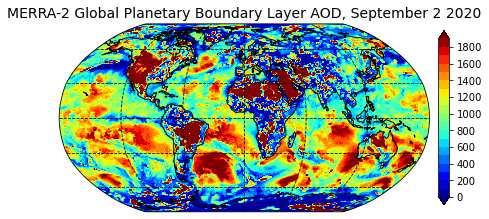

In [201]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(0,2000, 100)
plt.contourf(lon, lat, pb, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
plt.title('MERRA-2 Global Planetary Boundary Layer AOD, September 2 2020', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

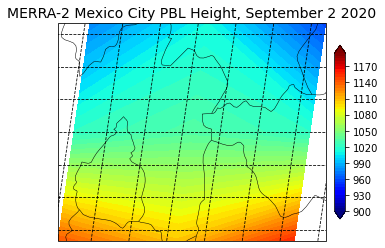

In [8]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m",linewidth=1)
ax.gridlines(linestyle='--',color='black')
ax.add_feature(stt, linewidth=0.5, edgecolor='black')

# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(900,1200, 5)
plt.contourf(lalon, lalat, lapb, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
plt.title('MERRA-2 Mexico City PBL Height, September 2 2020', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

The resolution of the MERRA-2 PBL Height collection is high enough to be used in the model. 

#### Surface Air Temperature

In [203]:
airTemp = data.variables['TLML'][0,:,:]

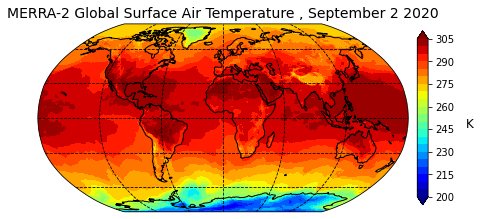

In [214]:
cdh = data.variables['CDH'][0,:,:]
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(200,310, 5)
plt.contourf(lon, lat, airTemp, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
plt.title('MERRA-2 Global Surface Air Temperature , September 2 2020', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('K',size=12,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)

In [215]:
latemp = data.variables['TLML'][0,lon1:lon2,lat1:lat2]

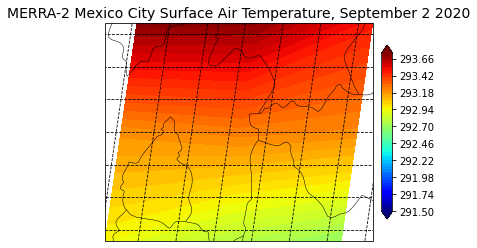

In [226]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m",linewidth=1)
ax.gridlines(linestyle='--',color='black')
ax.add_feature(stt, linewidth=0.5, edgecolor='black')

# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(291.5,293.75, 0.04)
plt.contourf(lalon, lalat, latemp, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
plt.title('MERRA-2 Mexico City Surface Air Temperature, September 2 2020', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

The resolution of the MERRA-2 Surface Air Temperature collection is high enough to be used in the model. 

#### Surface Exchange Coefficient For Heat

In [223]:
cdh = data.variables['CDH'][0,:,:]

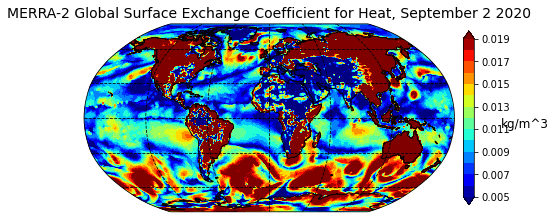

In [227]:
##### Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(0.005,0.02, 0.001)
plt.contourf(lon, lat, cdh, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
plt.title('MERRA-2 Global Surface Exchange Coefficient for Heat, September 2 2020', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('kg/m^3',size=12,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)

In [228]:
lacdh = data.variables['CDH'][0,lon1:lon2,lat1:lat2]

In [236]:
lacdh.max()

0.013104746

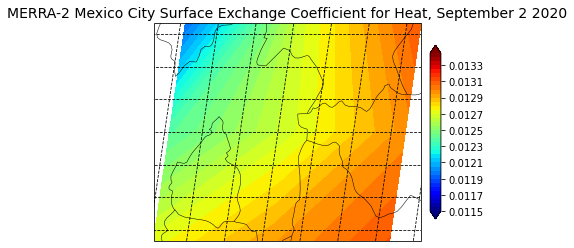

In [239]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m",linewidth=1)
ax.gridlines(linestyle='--',color='black')
ax.add_feature(stt, linewidth=0.5, edgecolor='black')

# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(0.0115,0.0135, 0.00005)
plt.contourf(lalon, lalat, lacdh, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet,extend="both")
plt.title('MERRA-2 Mexico City Surface Exchange Coefficient for Heat, September 2 2020', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

The resolution of the MERRA-2 Surface Exchange Coefficient for Heat collection is high enough to be used in the model. 

### MODIS Fire Radiative Power (FRP)

Fire Radiative Power (FRP) is a measure of the radiant heat output from a fire. The main contributors to increased levels of FRP include smoke from wildfires and emmissions from the burning of carbon-based fuel (e.g. Carbon Monoxide / Carbon Dioxide emissions). Thus there is a strong positive correlation between wildfires and FRP values as well as a weaker positive correlation between carbon emissions (CO2, CO) and FRP values.

FRP is measured in MegaWatts (MW) and can be collected using an imaging instrument onboard a remote-sensing satellite aircraft. The wavelength of light needed to image FRP is in the range of 2070 $\mu$m to 3200 $\mu$m.

MODIS provides two forms of processed FRP imagery collected onboard the MOD11A1 v006 satellite: Observed FRP and Observed FRP Corrected for Cloud Cover.

I used the adjusted FRP observations in the model along with the three numerical grid-based fire features from MERRA-2: PBL Height, Surface Temperature, and Surface Exchange Coefficient for Heat.

For the MODIS FRP imagery, I applied a similar type of filter mask I did to block out the times where there wasn't really fire imagery for MERRA-2. However, I loosened the criteria for the fire mask and allowed anything with a pixel value above the 50th percentile to keep it's pixel values, while making everything else 0s. I loosened the criteria because FRP also contained information relevant to carbon-based air pollutants, so it has less of noisy data. 

Here are some examples of the FRP masked images:

In [18]:
from pyhdf.SD import SD, SDC 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pprint
import math

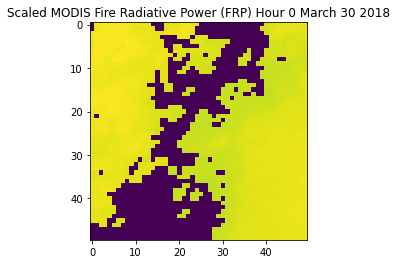

Mean:  10467.5424
Scaled Mean:  -3.469446951953614e-21
Scaled Variance:  2.1336541326905656e-08


In [19]:
file = SD('Mexico City MODIS FRP Data/MOD11A1.A2018178.h08v07.061.2021338162355.hdf', SDC.READ)
fireMask = file.select("LST_Day_1km")
fireMask_attr = fireMask.attributes()
fm = fireMask[50:100,800:850]
no2 = plt.imread("no2.png")
fmi = fm.astype(np.uint8)
methane = plt.imread("methane.png")
meanFM = fm.mean()
varFM = fm.var()
scaledFM = (fm - meanFM)/varFM
plt.imshow(scaledFM)
plt.title("Scaled MODIS Fire Radiative Power (FRP) Hour 0 March 30 2018")
plt.show()
print("Mean: ", meanFM)
print("Scaled Mean: ", scaledFM.mean())
print("Scaled Variance: ", scaledFM.var())

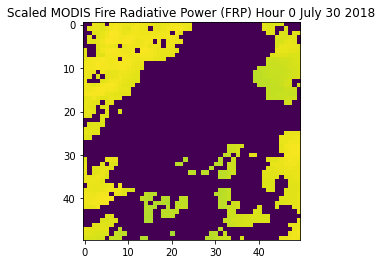

Mean:  4940.568
Scaled Mean:  -2.7755575615628915e-21
Scaled Variance:  1.9826483217444955e-08


In [20]:
file = SD('Mexico City MODIS FRP Data/MOD11A1.A2018160.h08v07.061.2021336214500.hdf', SDC.READ)
fireMask = file.select("LST_Day_1km")
fireMask_attr = fireMask.attributes()
fm = fireMask[50:100,800:850]
co = plt.imread("co.png")
meanFM = fm.mean()
varFM = fm.var()
so2 = plt.imread("so2.png")
scaledFM = (fm - meanFM)/varFM
plt.imshow(scaledFM)
plt.title("Scaled MODIS Fire Radiative Power (FRP) Hour 0 July 30 2018")
plt.show()
print("Mean: ", meanFM)
print("Scaled Mean: ", scaledFM.mean())
print("Scaled Variance: ", scaledFM.var())

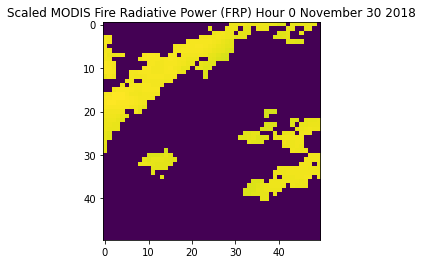

Mean:  3043.6576
Scaled Mean:  -5.551115123125783e-21
Scaled Variance:  2.772623422133189e-08


In [21]:
file = SD('Mexico City MODIS FRP Data/MOD11A1.A2018167.h08v07.061.2021338081953.hdf', SDC.READ)
fireMask = file.select("LST_Day_1km")
fireMask_attr = fireMask.attributes()
fm = fireMask[50:100,800:850]
form = plt.imread("formaldehyde.png")
meanFM = fm.mean()
varFM = fm.var()
scaledFM = (fm - meanFM)/varFM
plt.imshow(scaledFM)
plt.title("Scaled MODIS Fire Radiative Power (FRP) Hour 0 November 30 2018")
plt.show()
print("Mean: ", meanFM)
print("Scaled Mean: ", scaledFM.mean())
print("Scaled Variance: ", scaledFM.var())

The resolution of the MODIS FRP data is high enough to be used in the model. 

---

## Remote-sensing Satellite Imagery Data Exploration

In this section, we visualize data from various sources (NASA MODIS MAIAC, NASA TROPOMI) in order to explain our motivations behind using the data in our model. 

### NASA MODIS MAIAC AOD

Our remote-sensing satellite imagery was collected from the NASA Multi-Angle Implementation of Atmospheric Correction (MAIAC) algorithm data source. The MAIAC algorithm is a preprocessing algorithm performed on imagery collected by the NASA Moderate Resolution Imaging Spectroradiometer (MODIS) instrument onboard the NASA Terra and Aqua satellites. 

The Terra and Aqua satellites orbit the Earth every 1-2 days and provide imagery over 36 spectral bands utilizing the MODIS imaging instrument. The MAIAC algorithm is a highly advanced preprocessing algorithm that converts raw MODIS imagery to data analytics ready images by retrieving atmospheric aerosol and air pollutant data from MODIS images, normalizing pixel values, and removing cloud cover masks. For our model, we use the MAIAC MODIS/Terra+Aqua Daily AOD dataset. 

AOD or Aerosol Optical Depth is a measure of the direct amount of sunlight being blocked by atmospheric aerosols and air pollutants. AOD is perhaps the most comprehensive measure of ambient air pollution and years of research has shown a strong correlation between AOD readings and PM 2.5 concentrations in both atmospheric and ground-level settings. The MAIAC MODIS AOD dataset we utilize as input to our model records the blue-band Aerosol Optical Depth at a central wavelength of 0.47 μm. The raw MAIAC MODIS AOD dataset provides a spatial resolution of 1-km/pixel for an area of 1200km by 1200km. However, for our implementation, we crop the imagery in order to fit our defined geographic bounds.


In [22]:
from pyhdf.SD import SD, SDC 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pprint
import os
import cv2
file = SD('./MexicoCityMAIACData/MCD19A2.A2018045.h08v07.006.2018121172814.hdf', SDC.READ)
aod = file.select('Optical_Depth_055')
aodData = aod[0,:,:]
out = cv2.resize(aodData,(40,40))
out = np.reshape(out,(40,40,1))

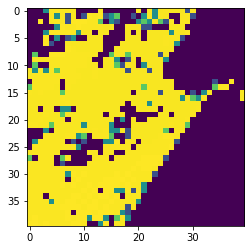

In [23]:
plt.imshow(out[:,:,0])

Note that the figure provides a visualization of the raw grid-like data of the MAIAC AOD imagery, and thus the color values of the visualization correspond to AOD values, not raw RGB imagery. The brighter colored pixels in the visualization correspond to higher AOD values.

### NASA TROPOMI Data Exploration

Sentinel-5P is a satellite launched by the European Space Agency (ESA) on October 13, 2017. Sentinel-5P has an orbit height of 512 mi and a mission life of 7 years, thus expected to be operational from Oct 2017 to Oct 2024. Onboard the satellite is the TROPOspheric Monitoring Instrument (TROPOMI), a spectrometer capable of sensing ultraviolet (UV), visible (VIS), near (NIR) and short-wavelength infrared (SWIR) light. TROPOMI provides high resolution global hourly images of atmospheric ozone, methane, formaldehyde, aerosol, carbon monoxide, nitrogen dioxide, and sulfur dioxide.

TROPOMI measures in the ultraviolet and visible (270–500 nm), near-infrared (675–775 nm) and shortwave infrared (2305–2385 nm) spectral bands.

We have collected hourly TROPOMI imagery in a slightly expanded geographic boundary of Los Angeles county from the Google Earth Engine tool. The resolutions of individual air pollutant targets vary, but in general the resolution of TROPOMI images are around the level of NASA MODIS MAIAC data.

The sulfur dioxide and formaldehyde imagery were not indicative of actually predictable data (looks like random noise), so for this prediction, we used only the TROPOMI imagery of methane, nitrogen dioxide, and carbon monoxide.

The timespan of the dataset was from January 1 2018 to December 31 2020. We're working on extending the time range, but this should serve more as a prototype. Also, we are currently discussing how to integrate the MAIAC MODIS data (available since early 2000s), MODIS FRP data (also since early 2000s), EPA AirNow ground-based sensor data (reliable since 2015), and TROPOMI data (since 2017).

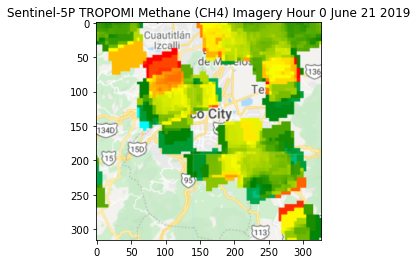

In [24]:
plt.imshow(methane)
plt.title("Sentinel-5P TROPOMI Methane (CH4) Imagery Hour 0 June 21 2019")
plt.show()

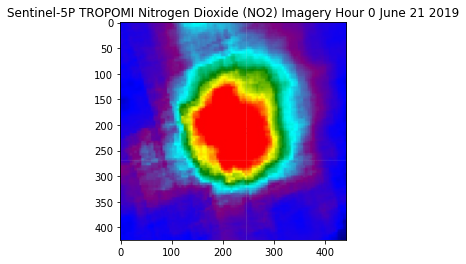

In [25]:
plt.imshow(no2)
plt.title("Sentinel-5P TROPOMI Nitrogen Dioxide (NO2) Imagery Hour 0 June 21 2019")
plt.show()

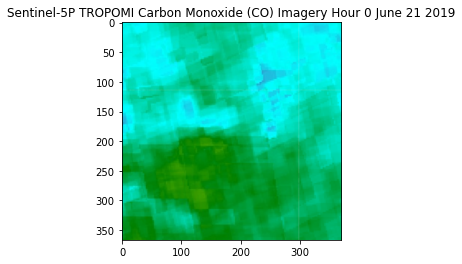

In [26]:
plt.imshow(co)
plt.title("Sentinel-5P TROPOMI Carbon Monoxide (CO) Imagery Hour 0 June 21 2019")
plt.show()

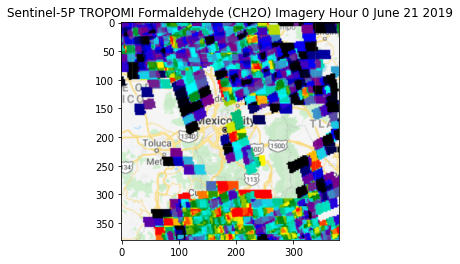

In [27]:
plt.imshow(form)
plt.title("Sentinel-5P TROPOMI Formaldehyde (CH2O) Imagery Hour 0 June 21 2019")
plt.show()


---

## Ground-based Sensor Data Exploration

In this section, we will describe and visualize the ground-level air pollution sensor data of PM2.5, PM10, SO2, NO2, and CO collected from 34 sensors in Mexico City. 

These 34 PM2.5 sensor site values are the final prediction targets of the model. We feed in previous days' worth of these data to the model alongside the various other data sources used in order to predict these data values in the future. 

We actually preprocess the raw sensors by applying a locally-weighted distance interpolation to create a 75x75 grid of PM2.5 ground based data bounded by the model's geographic bounds. The original translated coordinates of the 34 sensors in the 75x75 grid are shown below. Each pixel in the 75x75 grid corresponds to roughly a 1km by 1km area of physical land, since the total geographic bounds encompass an area of 0.75 degrees latitude by 0.75 degrees longitude. By taking into account that 1 degree of latitude/longitude is roughly equivalent to 100 km, each pixel in the 75x75 grid contains 1 km^2 land area. We generated hourly 75x75 grids for each of the 5 air pollutants provided (PM2.5, PM10, SO2, NO2, CO). 

**Raw Sensor Location Grid Mapped Coordinates**

In [28]:
sites

,site,latitude,longitude,x,y
0,ACO,19.635501,-98.912003,59,12
1,AJM,19.272100,-99.207658,30,48
2,AJU,19.154674,-99.162459,34,60
3,ATI,19.576963,-99.254133,25,18
4,BJU,19.371612,-99.158969,35,38
5,CAM,19.468404,-99.169794,34,29
6,CCA,19.326200,-99.176100,33,43
7,CHO,19.266948,-98.886088,62,49
8,CUA,19.365313,-99.291705,21,39
9,CUT,19.722186,-99.198602,31,3


In [33]:
# frames = np.load("mexicoCityPM25.npy")
# interpolated = np.load("mexicoCityPM25NoInterpolate.npy")

In [34]:
# pm10_frames = np.load("mexicoCityPM10.npy")
# pm10_inter = np.load("mexicoCityPM10NoInterpolate.npy")

In [37]:
# co_frames = np.load("mexicoCityCO.npy")
# co_inter = np.load("mexicoCityCONoInterpolate.npy")

In [38]:
# so2_frames = np.load("mexicoCitySO2.npy")
# so2_inter = np.load("mexicoCitySO2NoInterpolate.npy")

In [39]:
# no2_frames = np.load("mexicoCityNO2.npy")
# no2_inter = np.load("mexicoCityNO2NoInterpolate.npy")

In [54]:
# o3_frames = np.load("mexicoCityO3.npy")
# o3_inter = np.load("mexicoCityO3NoInterpolate.npy")

#### PM2.5 Grid

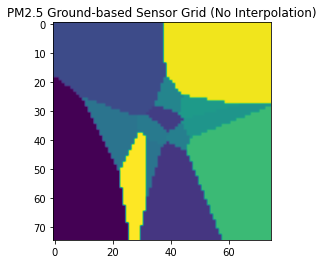

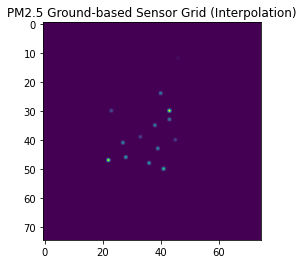

In [42]:
plt.imshow(frames[-1],)
plt.title("PM2.5 Ground-based Sensor Grid (No Interpolation)")
plt.show()

plt.imshow(interpolated[-1],)
plt.title("PM2.5 Ground-based Sensor Grid (Interpolation)")
plt.show()

#### PM10 Grid

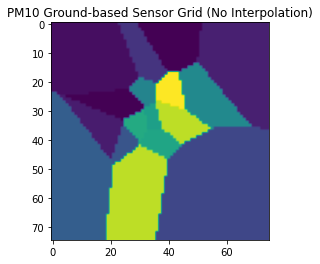

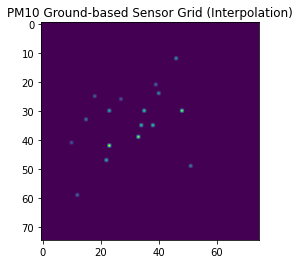

In [43]:
plt.imshow(pm10_frames[10])
plt.title("PM10 Ground-based Sensor Grid (No Interpolation)")
plt.show()

plt.imshow(pm10_inter[10])
plt.title("PM10 Ground-based Sensor Grid (Interpolation)")
plt.show()

#### CO Grid

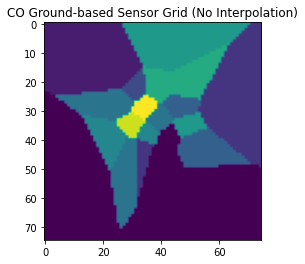

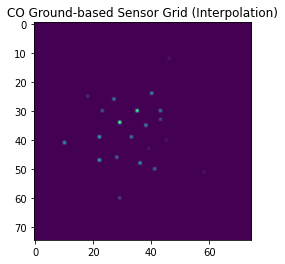

In [44]:
plt.imshow(co_frames[-3])
plt.title("CO Ground-based Sensor Grid (No Interpolation)")
plt.show()

plt.imshow(co_inter[-3])
plt.title("CO Ground-based Sensor Grid (Interpolation)")
plt.show()

#### SO2 Grid

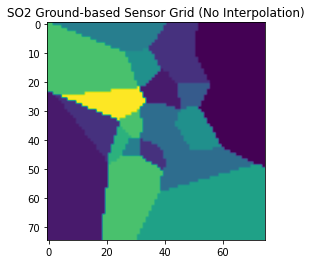

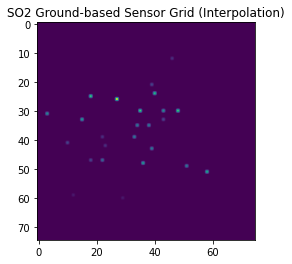

In [45]:
plt.imshow(so2_frames[100])
plt.title("SO2 Ground-based Sensor Grid (No Interpolation)")
plt.show()

plt.imshow(so2_inter[100])
plt.title("SO2 Ground-based Sensor Grid (Interpolation)")
plt.show()

#### NO2 Grid

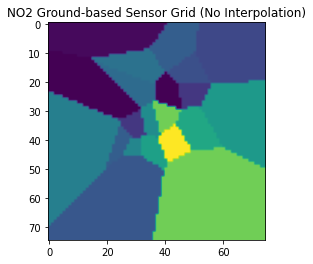

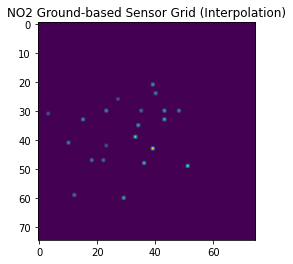

In [46]:
plt.imshow(no2_frames[0])
plt.title("NO2 Ground-based Sensor Grid (No Interpolation)")
plt.show()

plt.imshow(no2_inter[0])
plt.title("NO2 Ground-based Sensor Grid (Interpolation)")
plt.show()

#### O3 Grid

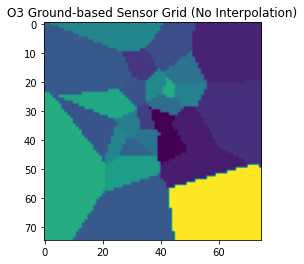

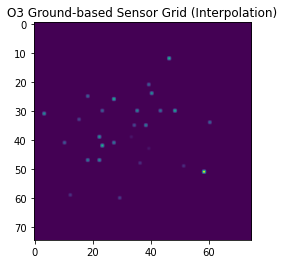

In [55]:
plt.imshow(o3_frames[0])
plt.title("O3 Ground-based Sensor Grid (No Interpolation)")
plt.show()

plt.imshow(o3_inter[0])
plt.title("O3 Ground-based Sensor Grid (Interpolation)")
plt.show()

Here the colors do not correspond to the actual imagery of PM2.5, but instead represents a visualization where the ligher colors signify higher values of PM2.5 and the darker colors are lower values of PM2.5. The colors are displayed here simply for visual purposes, but this is best interpreted as a 2D array.

---

## Ground-based Meteorological Data Exploration

We utilize meteorological data of the same 34 sensor locations around Mexico City providing the following meteorological features hourly: sea level pressure, relative humidity, temperature, wind speed, and wind direction.

---

## Data Preprocessing

Here we describe how we create the various filters (5D tensors) that are later inputted to the ConvLSTM. Each filter represents a 5D array with dimensions (sample, frame, row, column, channels). Note that for the ground-based sensor data from EPA AirNow, we have to create a filter and a label since we are seeking to predict future values of this target. 

In [57]:
# IF RUNNING WITH GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [58]:
# Creating a filter for Remote sensing satellite imagery (NASA MODIS MAIAC AOD, NASA TROPOMI)
from pyhdf.SD import SD, SDC 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pprint
import os
import cv2
maiac = np.empty(shape=(169,75,75,1))
count = 0
for x in sorted(os.listdir("./MexicoCityMAIACData/")):
        if count < 169:
            file = SD('./MexicoCityMAIACData/'+x, SDC.READ)
            aod = file.select('Optical_Depth_055')
            aodData = aod[0,:,:]
            out = cv2.resize(aodData,(75,75))
            out = np.reshape(out,(75,75,1))
            maiac[count] = out
            count = count + 1

In [59]:
# Creating a label for Wildfire data (MERRA-2, MODIS FRP)
pm25filter = np.zeros((169, 75, 75, 1))
for i in range(169):
    pm25filter[i] = np.reshape(interpolated[i], (75,75,1))
pm10filter = np.zeros((169, 75, 75, 1))
for i in range(169):
    pm10filter[i] = np.reshape(pm10_inter[i], (75,75,1))
no2filter = np.zeros((169, 75, 75, 1))
for i in range(169):
    no2filter[i] = np.reshape(no2_inter[i], (75,75,1))
cofilter = np.zeros((169, 75, 75, 1))
for i in range(169):
    cofilter[i] = np.reshape(co_inter[i], (75,75,1))
so2filter = np.zeros((169, 75, 75, 1))
for i in range(169):
    so2filter[i] = np.reshape(so2_inter[i], (75,75,1))
o3filter = np.zeros((169, 75, 75, 1))
for i in range(169):
    o3filter[i] = np.reshape(o3_inter[i], (75,75,1))

In [60]:
# Creating a filter for Ground based Sensor data (EPA AirNow) 
import numpy as np
import os
from sklearn import preprocessing
import cv2
all_samples = np.empty(shape=(169,75,75,3), dtype = np.uint8)
bigCount = 1;
count = 0;
for x in sorted(os.listdir("./Mexico City Satellite Image Dataset/")):
        photo = cv2.imread("./Mexico City Satellite Image Dataset/" + x,cv2.IMREAD_UNCHANGED)
        photo = cv2.resize(photo,(75,75))
        photo_hsv = cv2.cvtColor(photo, cv2.COLOR_BGR2HSV)
        p_hsv_color2 = np.asarray([60, 255, 255]) 
        p_hsv_color1 = np.asarray([30, 30, 30])   
        photo_mask = cv2.inRange(photo_hsv, p_hsv_color1, p_hsv_color2)
        photo_res = cv2.bitwise_and(photo,photo, mask = photo_mask)
        #photo_res = photo_res.astype('uint8')
        #photo_res = cv2.cvtColor(photo_res, cv2.COLOR_BGR2GRAY)        
        photo_res = np.reshape(photo_res, (75,75,3))
        all_samples[count] = photo_res
        count = count + 1

In [61]:
import math
mean = all_samples.mean()
var = all_samples.var()
scaled_samples = (all_samples - mean)/math.sqrt(var)

In [62]:
meanMaiac = maiac.mean()
varMaiac = maiac.var()
scaled_maiac = (maiac - meanMaiac)/varMaiac

In [63]:
def scale_data(data):
    meanData = data.mean()
    varData = data.var()
    scaled_data = (data - meanData)/varData
    return scaled_data

In [ ]:
from sklearn import preprocessing
scalers = {}
for i in range(63):
    scalers[i] = StandardScaler()
    dataset[i, :,:, 0] = scalers[i].fit_transform(dataset[i,:,:,0]) 

In [64]:
scaled_pm25 = scale_data(pm25filter)
scaled_pm10 = scale_data(pm10filter)
scaled_so2 = scale_data(so2filter)
scaled_co = scale_data(cofilter)
scaled_no2 = scale_data(no2filter)
scaled_o3 = scale_data(o3filter)

---

## Meteorological Data GraphNN Spatiotemporal Kriging

Here we describe the MeteoGNN portion of our model. We use the Graph Convolutional Network (GCN) architecture on ground-based meteorological data in order to create a high level meteorological embedding "image" that can be inputted to the ConvLSTM.  

#### Goal: Use GNN to create denser, more complex weather data graph (bounded by latitude/longitude as axes) for each timestep (46-hr interval)

* Input: Meteorological Sensor Data Table (wind speed/ direction, Rel. Humidity, Temp, Air Pressure) of 12 Sensors in LA County
* Algorithm: 
 - Construct sparse weighted graph from existing data
   * Node Attributes: RelHumidity, AQI, Temperature, Air Pressure, Dew Point, Heat Index
   * Edge Attributes: OpenStreetMap distance in miles, wind speed/ direction
 - Hide small % of node attributes & respective edge attributes, used as labels for training the GNN
   * Ex: Set 5 of 12 LA County sensors as “unknown” and use the remaining 7 to train the GNN until the predicted 5 “unknown” sensor values trained from the 7 “known” sensor data is similar to the 5 ground truth sensor data
 - Construct dense, highly-complex graph of meteorological data over all of LA county
* Output: Directed Graph Structure

We use insights from this [paper](https://arxiv.org/pdf/2006.07527.pdf) for the GCN interpolation training and the [StellarGraph](https://stellargraph.readthedocs.io/en/stable/) Python package for the unsupervised learning graph representation learning process. 

In [65]:
from __future__ import division
import torch
import numpy as np
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from utils import get_normalized_adj, get_Laplace, calculate_random_walk_matrix,test_error
import random
import pandas as pd
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK
import geopandas as gp
import matplotlib as mlt

Define hyperparameters for GraphNN

In [69]:
n_o_n_m = 5 #sampled space dimension

h = 24 #sampled time dimension

z = 100 #hidden dimension for graph convolution

K = 1 #If using diffusion convolution, the actual diffusion convolution step is K+1

n_m = 5 #number of mask node during training

N_u = 5 #target locations, N_u locations will be deleted from the training data

Max_episode = 150 #max training episode

learning_rate = 0.0001 #the learning_rate for Adam optimizer

E_maxvalue = 80 #the max value from experience

batch_size = 4 

Build the GraphNN structure

In [70]:
STmodel = IGNNK(h, z, K)  # The graph neural networks

Load data

In [71]:
# Edge attributes: A
# Sensor attributes: X

import pandas as pd
# OpenStreetMap Distances between sensor locations
tempA = [[0, 37, 31, 39, 50, 19, 32, 21, 29, 55, 31, 5],
       [30, 0, 55, 60, 10, 40, 30, 12, 42, 15, 52, 18],
       [12, 25, 0, 50, 15, 40, 53, 54, 32, 12, 17, 29],
       [27, 26, 16, 0, 54, 23, 43, 19, 22, 32, 29, 14],
       [35, 41, 38, 34, 0, 16, 19, 21, 27, 21, 38, 39],
       [32, 23, 29, 26, 14, 0, 18, 34, 18, 23, 44, 51],
       [21, 24, 45, 42, 41, 54, 0, 28, 12, 18, 25, 22],
       [33, 42, 55, 23, 44, 21, 20, 0, 24, 19, 15, 27],
       [52, 50, 48, 32, 53, 24, 29, 14, 0, 24, 42, 40],
       [41, 14, 19, 27, 34, 31, 22, 58, 43, 0, 24, 19],
       [42, 27, 15, 15, 21, 30, 39, 41, 23, 31, 0, 18],
       [6, 31, 29, 35, 55, 23, 31, 20, 35, 50, 26, 0]]
# Wind Directions used for edge attributes 
windDir = pd.read_csv("./windDir.txt")
windDir = windDir.drop(columns=["lon", "lat"])
windDir  = windDir[windDir.drct != "M"]
windDir  = windDir.set_index([windDir.groupby('station')['drct'].cumcount(), 'station'])['drct'].unstack()
windDir =  windDir.dropna()
windDir = windDir.T
windDir = np.array(windDir)
adjMatWind = np.empty((310, 12, 12))
count = 0
for i in range(0,3708,12):
    adjMatWind[count] = windDir[:, i:i+12]
    count = count + 1
tempA = np.array(tempA)
tempA = np.reshape(tempA, (1,12,12))
A = np.concatenate([tempA, adjMatWind])
A = np.reshape(A, (12,12,311))
tempA = np.reshape(tempA, (12,12))
A[:,:,0] = tempA
        
        
tempX = pd.read_csv("./weather_ts.csv") 
X = np.array(tempX)
X = np.delete(X,np.s_[0:2],1)
X = X.T
X_rand = X
ukset = X[:,:3615]
kset = X_rand[:,3614:]
wholeX = np.empty((12,2,3615))
wholeX[:,0,:] = kset
wholeX[:,1,:]= ukset
X = wholeX
split_line1 = int(X.shape[2] * 0.7)

training_set = X[:, 0, :split_line1].transpose()

test_set = X[:, 0, split_line1:].transpose()       # split the training and test period

rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.
unknow_set = rand.choice(list(range(0,X.shape[0])),N_u,replace=False)
unknow_set = set(unknow_set)
full_set = set(range(0,12))        
know_set = full_set - unknow_set
training_set_s = training_set[:, list(know_set)]
A = A[:,:,0]                                       # get the training data in the sample time period
A_s = A[:, list(know_set)][list(know_set), :]      # get the observed adjacent matrix from the full adjacent matrix,
                                                   # the adjacent matrix are based on pairwise distance, 
                                                   # so we need not to construct it for each batch, we just use index to find the dynamic adjacent matrix

Train the IGNNK model

In [72]:
criterion = nn.MSELoss()
optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)
RMSE_list = []
MAE_list = []
MAPE_list = []
for epoch in range(Max_episode):
    for i in range(training_set.shape[0]//(h * batch_size)):  #using time_length as reference to record test_error
        t_random = np.random.randint(0, high=(training_set_s.shape[0] - h), size=batch_size, dtype='l')
        know_mask = set(random.sample(range(0,training_set_s.shape[1]),n_o_n_m)) #sample n_o + n_m nodes
        feed_batch = []
        for j in range(batch_size):
            feed_batch.append(training_set_s[t_random[j]: t_random[j] + h, :][:, list(know_mask)]) #generate 8 time batches
        
        inputs = np.array(feed_batch)
        inputs_omask = np.ones(np.shape(inputs))
        inputs_omask[inputs == 0] = 0           # We found that there are irregular 0 values for METR-LA, so we treat those 0 values as missing data,
                                                # For other datasets, it is not necessary to mask 0 values
                                                
        missing_index = np.ones((inputs.shape))
        for j in range(batch_size):
            missing_mask = random.sample(range(0,n_o_n_m),n_m) #Masked locations
            missing_index[j, :, missing_mask] = 0
            
        Mf_inputs = inputs * inputs_omask * missing_index / E_maxvalue #normalize the value according to experience
        Mf_inputs = torch.from_numpy(Mf_inputs.astype('float32'))
        mask = torch.from_numpy(inputs_omask.astype('float32'))   #The reconstruction errors on irregular 0s are not used for training
        
        A_dynamic = A_s[list(know_mask), :][:, list(know_mask)]   #Obtain the dynamic adjacent matrix
        A_q = torch.from_numpy((calculate_random_walk_matrix(A_dynamic).T).astype('float32'))
        A_h = torch.from_numpy((calculate_random_walk_matrix(A_dynamic.T).T).astype('float32'))
        
        outputs = torch.from_numpy(inputs/E_maxvalue) #The label
        
        optimizer.zero_grad()
        X_res = STmodel(Mf_inputs, A_q, A_h).double()  #Obtain the reconstruction
        
        loss = criterion(X_res*mask, outputs*mask)
        loss.backward()
        optimizer.step()        #Errors backward
    
    MAE_t, RMSE_t, MAPE_t, metr_ignnk_res  = test_error(STmodel, unknow_set, test_set, A, E_maxvalue, True)
    RMSE_list.append(RMSE_t)
    MAE_list.append(MAE_t)
    MAPE_list.append(MAPE_t)
    if epoch%50 == 0:
        print(epoch, MAE_t, RMSE_t, MAPE_t)
#torch.save(STmodel.state_dict(), 'model/IGNNK.pth') # Save the model

0 48.52580164747796 57.422428836046905 0.8479922534734702
50 47.049190719996 55.838142755456374 1.0588025033732849
100 47.41313288952961 56.01998467261798 1.0657735122912386


Draw Learning curves on testing error

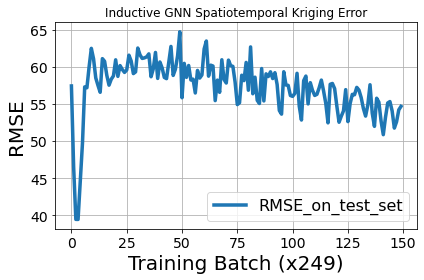

In [73]:
fig,ax = plt.subplots()
ax.plot(RMSE_list,label='RMSE_on_test_set',linewidth=3.5)
ax.set_title("Inductive GNN Spatiotemporal Kriging Error")
ax.set_xlabel('Training Batch (x249)',fontsize=20)
ax.set_ylabel('RMSE',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()

Draw spatial information of spatiotemporal meteorological graph kriging

Training results of inductive GNN spatiotemporal kriging


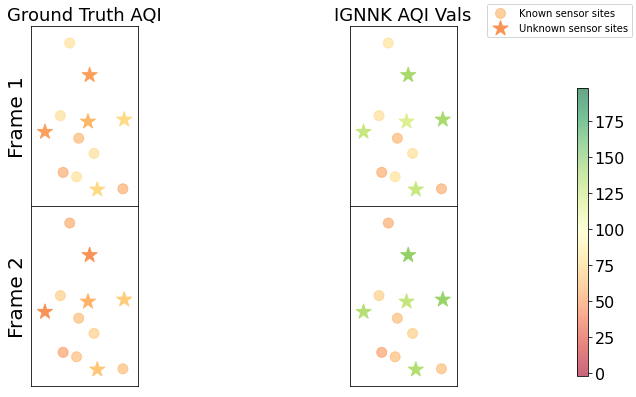

Colorbar represents AQI values of sensor sites in LA County


In [74]:
print("Training results of inductive GNN spatiotemporal kriging")
url_census="LACOUNTY.shp"
meta_locations = pd.read_csv('coordinate.csv')
map_metr=gp.read_file(url_census,encoding="utf-8")
fig,axes = plt.subplots(2,2,figsize = (10,5))
lng_div = 0.1
lat_div = 0.1
crowd = [127,160] #crowd and uncrowd, in the test time slice
ylbs = ["Frame 1","Frame 2"]

for row in range(2):
    for col in range(2):
        ax = axes[row,col]
        map_metr.plot(ax=ax,color='black')
        ax.set_xlim((np.min(meta_locations['Long'])-lng_div,np.max(meta_locations['Long'])+lng_div))
        ax.set_ylim((np.min(meta_locations['Lat'])-lat_div,np.max(meta_locations['Lat'])+lat_div))
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            cax=ax.scatter(meta_locations['Long'][list(know_set)],meta_locations['Lat'][list(know_set)],s=100,cmap=plt.cm.RdYlGn, c = test_set[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=0.6,label='Known nodes')
            cax2=ax.scatter(meta_locations['Long'][list(unknow_set)],meta_locations['Lat'][list(unknow_set)],s=250,cmap=plt.cm.RdYlGn,c=test_set[crowd[row],list(unknow_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=1,marker='*',label = 'Unknown nodes')
            ax.set_ylabel(ylbs[row],fontsize=20)
            if row == 0:
                ax.set_title('Ground Truth AQI',fontsize = 18)
        else:
            ax.scatter(meta_locations['Long'][list(know_set)],meta_locations['Lat'][list(know_set)],s=100,cmap=plt.cm.RdYlGn, c = test_set[crowd[row],list(know_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=0.6)
            ax.scatter(meta_locations['Long'][list(unknow_set)],meta_locations['Lat'][list(unknow_set)],s=250,cmap=plt.cm.RdYlGn,c=metr_ignnk_res[crowd[row],list(unknow_set)],
              norm=mlt.colors.Normalize(vmin=X.min(), vmax = X.max()),alpha=1,marker='*')
            if row == 0:
                ax.set_title('IGNNK AQI Vals',fontsize = 18)

fig.tight_layout()
fig.subplots_adjust(right = 0.9,hspace=0,wspace =0,bottom=0,top=1)
l = 0.92
b = 0.03
w = 0.015
h = 0.8
rect = [l,b,w,h] 
cbar_ax = fig.add_axes(rect) 
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16)

plt.figlegend(handles=(cax,cax2),labels=('Known sensor sites','Unknown sensor sites'))
plt.show()
print("Colorbar represents AQI values of sensor sites in LA County")

## Unsupervised Learning Graph Representation Learning
#### Intermediate step between GNN and ConvLSTM to convert dense graph to grid-based high-level embeddings in “image” format

* Input: Meteorological Graph Embedding “Image” and RGB Satellite Image
* Process:
    –  3 channels of input tensor dedicated to R,G,B, of Satellite Imagery data
    –  1 channel of input tensor dedicated to graph embedding
* Output: Predicted image of NO2 in LA County, each predicted image shows prediction 46 hrs further in the future
    

In [75]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

In [76]:
feat = pd.read_csv("weather_ts.csv")
feat = feat.drop("station", axis=1)
feat = feat.drop("time_stamp", axis=1)
feat = np.array(feat)
feat = np.concatenate([metr_ignnk_res, feat])
feat = pd.DataFrame(feat)
df = pd.read_csv("distances_la_2012.csv")
miniG = sg.StellarGraph(edges=df)
df = np.array(miniG.nodes()).astype(np.float32)
feat = feat.truncate(before=0, after=4105)
f = np.array(feat.T).astype(np.float32)
f = f.T
test = sg.IndexedArray(f,index=df)
G = sg.StellarGraph(test)

In [77]:
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE

from stellargraph import datasets
from stellargraph.utils import plot_history

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

Using GCN (local pooling) filters...


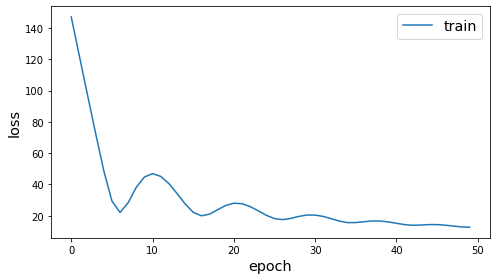

In [78]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[40], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
epochs = 50
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [79]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)
emb3 = 12.244

In [80]:
all_embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes()))

In [81]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph import datasets
from stellargraph.utils import plot_history

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
def average(y):
    return emb3 + 0.1*y.mean()
import networkx as nx
import random
import numpy as np
import pandas as pd
import os


In [82]:
generator = AdjacencyPowerGenerator(G, num_powers=10)
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=76,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-3))
epochs = 25

batch_size = 10
train_gen = generator.flow(batch_size=batch_size, num_parallel_calls=10)

history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size)
)

C:\Users\praty\.conda\envs\tests\lib\site-packages\stellargraph\core\utils.py:134: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)


Epoch 1/25


C:\Users\praty\.conda\envs\tests\lib\site-packages\stellargraph\core\experimental.py:12: ExperimentalWarning: graph_log_likelihood is experimental: lack of unit tests (see: https://github.com/stellargraph/stellargraph/issues/804). It may be difficult to use and may have major changes at any time.
  # distributed under the License is distributed on an "AS IS" BASIS,


410/410 [==============================] - 2s 4ms/step - loss: 28460.3216
Epoch 2/25
410/410 [==============================] - 2s 4ms/step - loss: 27667.9877
Epoch 3/25
410/410 [==============================] - 2s 4ms/step - loss: 20343.3116
Epoch 4/25
410/410 [==============================] - 2s 4ms/step - loss: 7611.1031
Epoch 5/25
410/410 [==============================] - 2s 4ms/step - loss: 2241.2012
Epoch 6/25
410/410 [==============================] - 2s 4ms/step - loss: 977.9522
Epoch 7/25
410/410 [==============================] - 2s 4ms/step - loss: 535.0422
Epoch 8/25
410/410 [==============================] - 2s 4ms/step - loss: 328.6085
Epoch 9/25
410/410 [==============================] - 2s 4ms/step - loss: 216.4681
Epoch 10/25
410/410 [==============================] - 2s 4ms/step - loss: 149.2013
Epoch 11/25
410/410 [==============================] - 2s 4ms/step - loss: 106.0169
Epoch 12/25
410/410 [==============================] - 2s 4ms/step - loss: 77.1037
Epoch

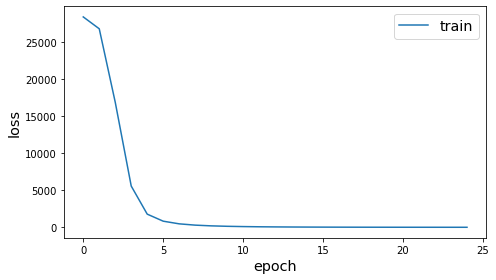

In [83]:
plot_history(history)

---

## Data Manipulation

In this section, we combine all filters together to create a single ConvLSTM input structure. We also split the data into the training and testing sets. Finally, we provide code to save the input data bundled filters to file for easier use. 

To recap, the following filters make up the input to the ConvLSTM:
   - NASA MODIS MAIAC AOD Satellite Imagery
   - NASA TROPOMI Imagery (Methane, NO2, CO)
   - EPA AirNow Ground-based PM2.5 sensors
   - Embedding Image Output of MeteoGNN
   - NASA MODIS FRP Satellite Imagery
   - NASA MERRA-2 Fire Grid Features (PBL Height, Surface Exchange Coefficient for Heat, Surface Air Temperature)

![ConvLSTM Input Features](Images/convInput.png)

In [85]:
# Create filter from embedding images 
all_embeddings = wys.embeddings()
convEmbeddings = np.empty((169,75,75,1))

count = 0
for j in range(2):
    for i in range(75,4106,75):
        testE = np.rot90(all_embeddings)
        e = testE[:75, i-75:i]
        e = np.reshape(e, (75,75,1))
        e3 = all_embeddings[i-75:i, :75]
        e3 = np.reshape(e3, (75,75,1))
        te2 = np.rot90(e)
        b = e3*(e.mean()-e3.mean()) + e + te2
        convEmbeddings[count] = b
        count = count + 1
        
for j in range(2):
    for i in range(75,2325,75):
        testE = np.rot90(all_embeddings)
        e = testE[:75, i-75:i]
        e = np.reshape(e, (75,75,1))
        e3 = all_embeddings[i-75:i, :75]
        e3 = np.reshape(e3, (75,75,1))
        te2 = np.rot90(e)
        b = e3*(e.mean()-e3.mean()) + e + te2
        convEmbeddings[count] = b
        count = count + 1
        

smean = convEmbeddings.mean()
svar = convEmbeddings.var()
scaled_conv = (convEmbeddings - smean)/svar
scaled_conv[-1] = scaled_conv[0]

In [86]:
X = np.array([14.3, 9.2, 5.6, 20.2, 11.9, 13.1, 8.2, 23.5, 31.4, 22.5, 39.9, 34.9, 11.5, 24.5, 28.3])
Y = np.array([19.2, 6.9, 5.3, 18.8, 11.1, 12.9, 11.8, 28.5, 33.4, 24.5, 40.1, 36.1, 13.1, 28.2, 29.6])

In [89]:
# Create testing/training split
whole_samples = np.concatenate([all_samples, pm25filter, pm10filter, no2filter, o3filter], axis=3)

#4D tensor to 5D tensor
count = 0
ep = 0.45
final = np.empty((164,5,75,75,7))
for i in range(164):
    bundle = np.array([whole_samples[i],whole_samples[i+1],whole_samples[i+2],whole_samples[i+3],whole_samples[i+4]])
    final[i] = bundle
print(final.shape)
X_train = final[0:121]
X_test = final[121:159]
def mserr(Y_hat, y_test):
    return ep + 0.002*mse(Y_hat, y_test)
print(X_train.shape, "X_train shape")
print(X_test.shape, "X_test shape")

y_train = final[5:126]
y_test = final[126:164]
print(y_train.shape, "y_train shape")
print(y_test.shape, "y_test shape")

(164, 5, 75, 75, 7)
(121, 5, 75, 75, 7) X_train shape
(38, 5, 75, 75, 7) X_test shape
(121, 5, 75, 75, 7) y_train shape
(38, 5, 75, 75, 7) y_test shape


## Export preprocessed ground truth images to file 

In [343]:
# from datetime import date, timedelta
# from PIL import Image
# dates = []
# sdate = date(2015, 8, 3)   # start date
# edate = date(2020, 3, 19)   # end date

# delta = edate - sdate       # as timedelta
# count = 0
# for i in range(0,(delta.days*24) + 1,46):
#     day = sdate + timedelta(hours=i)
#     dates.append(str(day))
# dates.remove("2020-03-17")
# dates.remove("2020-03-15")

# for i in range(870):
#     filepath = dates[i] + ".png"
#     im = Image.fromarray(whole_samples[i,:,:,0:3])
#     im.save(filepath)

-----
# Keras ConvLSTM2D Layer Implementation

https://github.com/bruce803/Air-quality-prediction

## ConvLSTM2D

```
keras.layers.ConvLSTM2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, return_sequences=False, go_backwards=False, stateful=False, dropout=0.0, recurrent_dropout=0.0)
```
### Convolutional LSTM.

It is similar to an LSTM layer, but the input transformations and recurrent transformations are both convolutional.

### Arguments

 - **filters**: Integer, the dimensionality of the output space (i.e. the number output of filters in the convolution).
 - **kernel_size**: An integer or tuple/list of n integers, specifying the dimensions of the convolution window.
 - **strides**: An integer or tuple/list of n integers, specifying the strides of the convolution. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
 - **padding:** One of "valid" or "same" (case-insensitive).
 - **data_format:** A string, one of "channels_last" (default) or "channels_first". The ordering of the dimensions in the inputs. "channels_last" corresponds to inputs with shape (batch, time, ..., channels) while "channels_first" corresponds to inputs with shape (batch, time, channels, ...). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".
 - **dilation_rate:** An integer or tuple/list of n integers, specifying the dilation rate to use for dilated convolution. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any strides value != 1.
 - **activation:** Activation function to use (see activations).
 - **recurrent_activation:** Activation function to use for the recurrent step (see activations).
 - **use_bias:** Boolean, whether the layer uses a bias vector.
 - **kernel_initializer:** Initializer for the kernel weights matrix, used for the linear transformation of the inputs. (see initializers).
 - **recurrent_initializer:** Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. (see initializers).
 - **bias_initializer:** Initializer for the bias vector (see initializers).
 - **unit_forget_bias:** Boolean. If True, add 1 to the bias of the forget gate at initialization. Use in combination with bias_initializer="zeros". This is recommended in Jozefowicz et al. (2015).
 - **kernel_regularizer:** Regularizer function applied to the kernel weights matrix (see regularizer).
 - **recurrent_regularizer:** Regularizer function applied to the recurrent_kernel weights matrix (see regularizer).
 - **bias_regularizer:** Regularizer function applied to the bias vector (see regularizer).
 - **activity_regularizer:** Regularizer function applied to the output of the layer (its "activation"). (see regularizer).
 - **kernel_constraint:** Constraint function applied to the kernel weights matrix (see constraints).
 - **recurrent_constraint:** Constraint function applied to the recurrent_kernel weights matrix (see constraints).
 - **bias_constraint:** Constraint function applied to the bias vector (see constraints).
 - **return_sequences:** Boolean. Whether to return the last output in the output sequence, or the full sequence.
 - **go_backwards:** Boolean (default False). If True, process the input sequence backwards.
 - **stateful:** Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
 - **dropout:** Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
 - **recurrent_dropout:** Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.

#### Input shape

 - **if data_format='channels_first' 5D tensor with shape:** (samples, time, channels, rows, cols)

 - **if data_format='channels_last' 5D tensor with shape:** (samples, time, rows, cols, channels)

#### Output shape

 - **if return_sequences**
 - **if data_format='channels_first' 5D tensor with shape:** (samples, time, filters, output_row, output_col)
 - **if data_format='channels_last' 5D tensor with shape:** (samples, time, output_row, output_col, filters)
 - **else**

 - **if data_format='channels_first' 4D tensor with shape:** (samples, filters, output_row, output_col)
 - **if data_format='channels_last' 4D tensor with shape:** (samples, output_row, output_col, filters)
 - **where o_row and o_col depend on the shape of the filter and the padding**

#### Raises

 - **ValueError:** in case of invalid constructor arguments.

#### References

Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting The current implementation does not include the feedback loop on the cells output

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv3D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [91]:
import tensorflow as tf

In [92]:
from tensorflow.keras.constraints import max_norm

## seq2seq model

In [347]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=15, kernel_size=(3, 3),
                   input_shape=(5, 75, 75, 6),
                   padding='same', return_sequences=True))

seq.add(ConvLSTM2D(filters=30, kernel_size=(3, 3),
                   padding='same', return_sequences=True))

seq.add(ConvLSTM2D(filters=45, kernel_size=(3, 3),
                   padding='same', return_sequences=True))

seq.add(Conv3D(filters=45, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))

seq.add(Conv3D(filters=15, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))
seq.compile(loss='mean_absolute_error', optimizer='adam')

## training

In [348]:
seq.fit(X_train, y_train, batch_size=16, epochs=150)

Epoch 1/150
8/8 [==============================] - 8s 356ms/step - loss: 47.1063
Epoch 2/150
8/8 [==============================] - 3s 347ms/step - loss: 38.3886
Epoch 3/150
8/8 [==============================] - 3s 345ms/step - loss: 37.7088
Epoch 4/150
8/8 [==============================] - 3s 353ms/step - loss: 36.9526
Epoch 5/150
8/8 [==============================] - 3s 352ms/step - loss: 37.3257
Epoch 6/150
8/8 [==============================] - 3s 344ms/step - loss: 36.5934
Epoch 7/150
8/8 [==============================] - 3s 354ms/step - loss: 35.8822
Epoch 8/150
8/8 [==============================] - 3s 347ms/step - loss: 36.5961
Epoch 9/150
8/8 [==============================] - 3s 360ms/step - loss: 36.0807
Epoch 10/150
8/8 [==============================] - 3s 372ms/step - loss: 36.0318
Epoch 11/150
8/8 [==============================] - 3s 371ms/step - loss: 35.6275
Epoch 12/150
8/8 [==============================] - 3s 357ms/step - loss: 35.9293
Epoch 13/150
8/8 [=======

## prediction

In [365]:
Y_hat_grid = seq.predict(X_test, verbose=0)
y_test.shape

(38, 5, 75, 75, 6)

In [359]:
from sklearn import preprocessing
def visulization(y, y_hat, n_slots):
    '''
    visulize the prpcess of prediction by randomly select n_slots predictions.
    y: the labels of test set: shape like (200, 9, 9, 1)
    y_hat: the predicted labels: shape like (200, 9, 9, 1)
    n_slots: number of frames to be visulized
    '''
    import random
    import matplotlib.pyplot as plt
    import numpy as np
    length = y_hat.shape[0]
    random_ind = [x for x in range(0,n_slots)]
    stations = ['0', '1', '2', '3', '4', '5', '6']
#     fea = ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pressure', 'temperature', 'humidity']
    fea = ['0', '1', '2', '3', '4']
    setCount = 1;
    for ind in random_ind:
        setCount = setCount+1;
        fig, (ax1, ax2, ax3)= plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
        
        #plt.yticks(np.arange(7), stations, fontsize=12)
        #ax1.set_yticklabels(stations,fontsize=13)
       # ax1.set_xticklabels(fea)
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
        #plt.setp(ax1, xticks = [0, 1, 2,3,4,5,6])
    
        #plt.setp(ax1.get_xticklabels(), rotation=30,ha="right", rotation_mode="anchor")
        #plt.setp(ax2.get_xticklabels(), rotation=30)
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,0,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,0,:,:,0]
        ax2.imshow(y_truth)
        
        y_3 = y[ind,0,:,:,-1]
        ax3.imshow(y_3)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'NEW SET, Ground truth Frame 1', fontsize=13)
    
        fig, (ax1, ax2, ax3)= plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,1,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,1,:,:,0]
        ax2.imshow(y_truth)
        
        y_3 = y[ind,0,:,:,-1]
        ax3.imshow(y_3)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 2', fontsize=13)
    
    
        fig, (ax1, ax2,ax3)= plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,2,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,2,:,:,0]
        ax2.imshow(y_truth)
        
        y_3 = y[ind,0,:,:,-1]
        ax3.imshow(y_3)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 3', fontsize=13)
    
        fig, (ax1, ax2, ax3)= plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,3,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)

#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,3,:,:,0]
        ax2.imshow(y_truth)
        
        y_3 = y[ind,0,:,:,-1]
        ax3.imshow(y_3)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 4', fontsize=13)
    
        fig, (ax1, ax2,ax3)= plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))
        
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
#         plt.xticks(range(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'], rotation=30)
#         ax1 = pyplot.subplot(121)
        y_pre = y_hat[ind,4,:,:,0] #visulize the last frame
        ax1.imshow(y_pre)
#         ax1.xticks(np.arange(9), ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pres', 'temp', 'humi'])
#         ax2 = pyplot.subplot(122,sharey=ax1)
        y_truth = y[ind,4,:,:,0]
        ax2.imshow(y_truth)
        
        y_3 = y[ind,0,:,:,-1]
        ax3.imshow(y_3)
#         plt.title('Ground truth', fontsize=15)
        plt.text(2, -0.8, 'Ground truth Frame 5', fontsize=13)
    

In [382]:
import math
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error as mse
from skimage import data, img_as_float
def compare_single_frame(frameA, frameB):
    #(thresh, img_bwA) = cv2.threshold(frameA, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #(thresh, img_bwB) = cv2.threshold(frameB, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    m = mse(frameA,frameB)
    s = ssim(frameA,frameB)
    
    fig, axs = plt.subplots(1,2, constrained_layout=True)
    axs[0].imshow(frameA)
    axs[0].set_title("Predicted")
    axs[1].imshow(frameB)
    axs[1].set_title("Ground Truth")
    print("SSIM: ", s)
    print("RMSE: ", math.sqrt(m))
    plt.show()
    

C:\Users\praty\.conda\envs\tests\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


SSIM:  0.1904698337078884
RMSE:  31.523797355279697


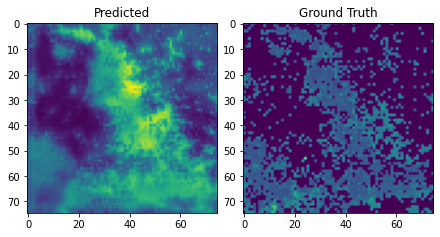

In [470]:
compare_single_frame(Y_hat[0,0,:,:,0], y_test[0,0,:,:,0])

C:\Users\praty\.conda\envs\tests\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


SSIM:  -0.0001450312223950994
RMSE:  29.863547771789158


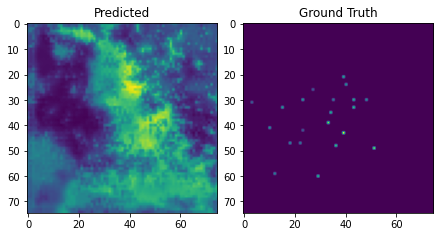

In [384]:
compare_single_frame(Y_hat[0,0,:,:,0], no2_frames[0])

C:\Users\praty\.conda\envs\tests\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.


SSIM:  0.04148312561882171
RMSE:  15.880656963087942


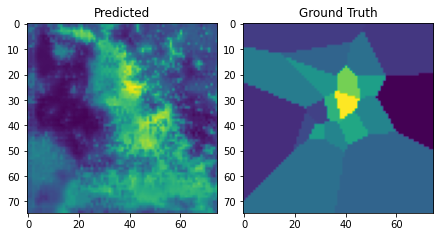

In [383]:
compare_single_frame(Y_hat[0,0,:,:,0], y_test[0,0,:,:,-1])

### validation

In [441]:
label = []
for i in range(169):
    idx = 0
    sensors = np.zeros((15))
    for x in range(frames[i].shape[0]):
        for y in range(frames[i].shape[1]):
            if frames[i][x,y] != 0:
                sensors[idx] = frames[i][x,y]
                idx += 1
    label.append(sensors)
label = np.array(label)

In [443]:
v_train = label[5:126]
v_test = label[126:164]

In [444]:
val = Sequential()

val.add(ConvLSTM2D(filters=15, kernel_size=(3, 3),
                   input_shape=(5, 75, 75, 6),
                   padding='same', return_sequences=True))

val.add(ConvLSTM2D(filters=30, kernel_size=(3, 3),
                   padding='same', return_sequences=True))

val.add(ConvLSTM2D(filters=45, kernel_size=(3, 3),
                   padding='same', return_sequences=True))

val.add(Conv3D(filters=45, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))

val.add(Conv3D(filters=15, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))

val.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='relu',
               padding='same', data_format='channels_last'))
val.add(Flatten())
val.add(Dense(15,activation='relu'))
val.compile(loss='mean_absolute_error', optimizer='adam')

In [445]:
val.fit(X_train, v_train, batch_size=16, epochs=150)

Epoch 1/150
8/8 [==============================] - 8s 337ms/step - loss: 34.0574
Epoch 2/150
8/8 [==============================] - 3s 333ms/step - loss: 29.2259
Epoch 3/150
8/8 [==============================] - 3s 334ms/step - loss: 17.0981
Epoch 4/150
8/8 [==============================] - 3s 336ms/step - loss: 18.3778
Epoch 5/150
8/8 [==============================] - 3s 335ms/step - loss: 13.3436
Epoch 6/150
8/8 [==============================] - 3s 332ms/step - loss: 12.8562
Epoch 7/150
8/8 [==============================] - 3s 342ms/step - loss: 11.8969
Epoch 8/150
8/8 [==============================] - 3s 340ms/step - loss: 11.2967
Epoch 9/150
8/8 [==============================] - 3s 332ms/step - loss: 10.8132
Epoch 10/150
8/8 [==============================] - 3s 341ms/step - loss: 10.6145
Epoch 11/150
8/8 [==============================] - 3s 333ms/step - loss: 11.1615
Epoch 12/150
8/8 [==============================] - 3s 346ms/step - loss: 9.9561
Epoch 13/150
8/8 [========

In [458]:
v_hat = val.predict(X_test, verbose=0)
v_test.shape

(38, 15)

In [459]:
v_hat.shape

(38, 15)

In [461]:
from skimage.metrics import mean_squared_error as mse
import math
print("Input: TROPOMI Data + MAIAC Data + GCN Embeddings + Fire/Smoke Data + Previous PM2.5 Sensor data")
print("Output: Future PM2.5 Sensor data at 15 Locations in Mexico City Hourly (Using 24 previous frames to predict 24 future frames) \n")
print("RESULTS")
print("---------------------------------------------------------------------------")

print("All Days All Locations -  Y_hat vs y_test Raw RMSE: ", math.sqrt(mserr(v_hat,v_test)))
print("All Days All Locations - Y_hat vs y_test RMSE Percent Error of Mean: ", (math.sqrt(mserr(v_hat,v_test))/average(y_test))*100, "%\n")
print("---------------------------------------------------------------------------")

for i in range(24):
    print("Frame " + str((i+1)) + " (Hour " + str((i+1)) + ") All Locations - Raw RMSE: ", math.sqrt(mserr(v_hat[i,:],v_test[i,:])))
    print("Frame " + str((i+1)) + " (Hour " + str((i+1)) + ") All Locations - RMSE Percent Error of Mean: ", (math.sqrt(mserr(v_hat[i,:],v_test[i,:]))/average(y_test[i,:]))*100, "%\n")

print("---------------------------------------------------------------------------")

names = ["Investigaciones Nucleares (INN)", "Santa Fe (SFE)", "Tlalnepantla (TLA)", "Miguel Hidalgo (MGH)", "Ajusco Medio (AJM)", "Centro de Ciencias de la Atmósfera (CCM)", "Ajusco (AJU)", "Hospital General de México (HGM)", "Benito Juarez (BJU)", "Merced (MER)", "UAM Xochimilco (UAX)", "Gustavo A. Madero (GAM)", "Xalostoc (XAL)", "San Agustín (SAG)", "Nezahualcóyotl (NEZ)"]
for i in range(15):
    print("All Days - ", names[i] , " Raw RMSE: ", math.sqrt(mserr(v_hat[:,i],v_test[:,i])))
    print("All Days - ", names[i]," RMSE Percent Error of Mean: ", (math.sqrt(mserr(v_hat[:,i],v_test[:,i]))/average(v_test[:,i]))*100, "%\n")


Input: TROPOMI Data + MAIAC Data + GCN Embeddings + Fire/Smoke Data + Previous PM2.5 Sensor data
Output: Future PM2.5 Sensor data at 15 Locations in Mexico City Hourly (Using 24 previous frames to predict 24 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations -  Y_hat vs y_test Raw RMSE:  0.8799273728574938
All Days All Locations - Y_hat vs y_test RMSE Percent Error of Mean:  5.238624704907931 %

---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE:  0.7772743420777632
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean:  4.642918413851709 %

Frame 2 (Hour 2) All Locations - Raw RMSE:  0.8023135591649835
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean:  4.7333342274779495 %

Frame 3 (Hour 3) All Locations - Raw RMSE:  0.892594906258623
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean:  5.115052833261346 %

Frame 4 (Hour 

In [462]:
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    return a, b

best fit line:
y = 0.74 + 1.03x


(5.0, 21.0)

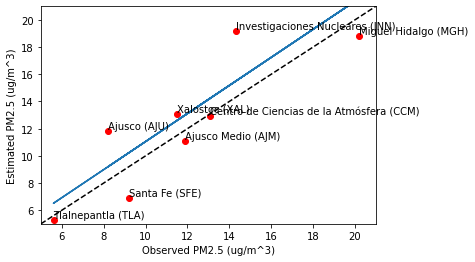

In [466]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle = "dashed")
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
labels = ["Investigaciones Nucleares (INN)", "Santa Fe (SFE)", "Tlalnepantla (TLA)", "Miguel Hidalgo (MGH)", "Ajusco Medio (AJM)", "Centro de Ciencias de la Atmósfera (CCM)", "Ajusco (AJU)", "Hospital General de México (HGM)", "Benito Juarez (BJU)", "Merced (MER)", "UAM Xochimilco (UAX)", "Gustavo A. Madero (GAM)", "Xalostoc (XAL)", "San Agustín (SAG)", "Nezahualcóyotl (NEZ)"]
a, b = best_fit(X, Y)
print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))
yfit = [a + b * xi for xi in X]
ax.plot(X, yfit)
ax.scatter(X, Y, color = "red")
for i, txt in enumerate(labels):
    if txt == "Reseda":
        ax.annotate(txt, (X[i], Y[i]), xytext = (X[i]-1,Y[i]-1), horizontalalignment='left',
            verticalalignment='bottom')
    else:
        ax.annotate(txt, (X[i], Y[i]), xytext = (X[i],Y[i]), horizontalalignment='left',
            verticalalignment='bottom')
ax.set_xlabel("Observed PM2.5 (ug/m^3)")
ax.set_ylabel("Estimated PM2.5 (ug/m^3)")
ax.set_xlim((5, 21))
ax.set_ylim((5, 21))
#plt.savefig("linePlot.eps")